In [ ]:
# need to add dataset to a folder in google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%tensorflow_version 2.x

In [2]:
! pip install SimpleITK
! pip install tensorflow-addons

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import os
from PIL import Image
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import SimpleITK as sitk
import pickle
from tensorflow import saved_model as sm

In [ ]:
def import_data_numpy(path):
    """
    Imports png images and returns as a list of tensors to be used in training
    :param path: path to directory where images are
    :return: list of Tensors
    """
    tensor_list = []
    for file in sorted(os.listdir(path)):
        if file.endswith(".png") or file.endswith(".tif"):
            # Converts to RGB because the vessel images are black and white
            png_img = Image.open(os.path.join(path, file))
            np_arr = normalize(np.array(png_img.getdata()).reshape((128, 128,3)))
            # tensor = tf.convert_to_tensor(np_arr)
            # Encodes images as tensors and adds to the list
            tensor_list.append(np_arr)
        # Returns list of tensors to be used in model
    # tensor_list = np.asarray(tensor_list)
    return np.asarray(tensor_list)


In [ ]:
def import_data_numpy_mask(path):
    """
    Imports png images and returns as a list of tensors to be used in training
    :param path: path to directory where images are
    :return: list of Tensors
    """
    tensor_list = []
    for file in sorted(os.listdir(path)):
        if file.endswith(".png") or file.endswith(".tif"):
            # Converts to RGB because the vessel images are black and white
            png_img = Image.open(os.path.join(path, file)).convert('L')
            np_arr = normalize(np.array(png_img.getdata()).reshape((128, 128,1)))
            # tensor = tf.convert_to_tensor(np_arr)
            # Encodes images as tensors and adds to the list
            tensor_list.append(np_arr)
        # Returns list of tensors to be used in model
    # tensor_list = np.asarray(tensor_list)
    return np.asarray(tensor_list)

In [ ]:
def normalize(input_image):
  max = np.max(input_image)
  input_image = tf.cast(input_image, tf.float32) / max
  return input_image

In [ ]:
from keras import backend as K    #import backend for custom metric

def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
def _encoder_block_unet(input, num_filters):
    """
    Encoder logic for U-Net
    :param input: KerasTensor
    :param num_filters: Int - number of output filters in convolution
    :return: KerasTensor
    """
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def _encoder_block_kinet(input, num_filters):
    """
    Encoder logic for Ki-Net
    :param input: KerasTensor
    :param num_filters: Int - number of output filters in convolution
    :return: KerasTensor
    """
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    p = layers.MaxPool2D((2, 2))(x)
    return x


def _decoder_block_unet(input, num_filters):
    """
    Decoder logic for U-Net
    :param input: KerasTensor
    :param num_filters: Int - number of output filters in convolution
    :return: KerasTensor
    """
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def _decoder_block_kinet(input, num_filters):
    """
    Decoder logic for Ki-net
    :param input: KerasTensor
    :param num_filters: Int - number of output filters in convolution
    :return: KerasTensor
    """
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    print(type(x))
    return x


def _crfb(x1, x2, num_filters, scale_factor):
    """
    CRFB is the cross residual fusion block which fuses the outputs at the specified layers
    from one model to the other, and returns the results as input for the next step.
    :param x1: KerasTensor
    :param x2: KerasTensor
    :param num_filters: Int - number of output filters in convolution
    :param scale_factor: Float - scale factor for resizing (upsampling/downsampling) of output
    :return: KerasTensor
    """
    new_w = int(x2.shape[1] * scale_factor)
    new_h = int(x2.shape[2] * scale_factor)
    out = layers.Conv2D(num_filters, 3, padding="same")(x2)
    out = layers.Activation("relu")(out)
    out = tf.image.resize(out, [new_h, new_w])
    output = layers.Add()([x1, out])
    return output

In [ ]:
def kiunet(input_shape, num_classes):
    """
    Architecture of the KiU-Net model, which combines the Ki-Net and U-Net architecture
    :param input_shape: Tuple of the shape of the input
    :return: keras.Model
    """
    inputs = layers.Input(shape=input_shape)

    # ENCODER BLOCK #

    s1 = _encoder_block_unet(inputs, 16)  # U NET ENCODER
    k1 = _encoder_block_kinet(inputs, 16)  # KINET ENCODER
    
    u1 = _crfb(s1, k1, 16, 0.25)  # CRFB U1 UNET
    o1 = _crfb(k1, s1, 16, 4)  # CRFB O1 KINET
    
    s2 = _encoder_block_unet(u1, 32)  # UNET ENCODER
    k2 = _encoder_block_kinet(o1, 32)  # KINET ENCODER
    
    u2 = _crfb(s2, k2, 32, 0.0625)  # CRFB U2 UNET
    o2 = _crfb(k2, s2, 32, 16)  # CRFB O2 KINET
    

    s3 = _encoder_block_unet(u2, 64)  # UNET ENCODER
    k3 = _encoder_block_kinet(o2, 64)  # KINET ENCODER
    

    u3 = _crfb(s3, k3, 64, 0.015625)  # CRFB U3 UNET
    o3 = _crfb(k3, s2, 64, 32)  # CRFB O3 KINET
    

    # DECODER BLOCK #

    d1_u = _decoder_block_unet(u3, 32)  # UNET DECODER
    d1_k = _decoder_block_kinet(o3, 32)  # KINET DECODER
    

    d_u1 = _crfb(d1_u, d1_k, 32, 0.0625)  # CRFB D_U1 UNET
    
    d_o1 = _crfb(d1_k, d1_u, 32, 16)  # CRFB D_O1 KINET
    

    out = layers.Add()([d_u1, s2])  # CONCATENTATION D_U1 & S2 UNET
    out1 = layers.Add()([d_o1, k2])  # CONCATENTATION D_O1 & K2 KINET
    

    d2_u = _decoder_block_unet(out, 16)  # UNET DECODER
    d2_k = _decoder_block_kinet(out1, 16)  # KINET DECODER
   

    d_u2 = _crfb(d2_u, d2_k, 16, 0.25)  # CRFB D_U2 UNET
    d_o2 = _crfb(d2_k, d2_u, 16, 4)  # CRFB D_O2 KINET
    

    out = layers.Add()([d_u2, s1])  # CONCATENATION D_U2 & S1 UNET
    out1 = layers.Add()([d_o2, k1])  # CONCATENATION D_O2 & K2 KINET
    

    d3_u = _decoder_block_unet(out, 8)  # UNET DECODER
    d3_k = _decoder_block_kinet(out1, 8)  # KINET DECODER
    

    out = layers.Add()([d3_u, d3_k])  # FINAL CONCATENATION OUTPUT FROM UNET AND KINET

    out = layers.Conv2D(num_classes, 1, padding="valid", activation="relu")(out)  # FINAL CONVOLUTIONAL LAYER
    kiunet_model = keras.Model(inputs, out, name="KiU-Net")  # MODEL

    return kiunet_model

In [ ]:
def unet_from_code(input_shape, num_classes):
    """
    Architecture of the U-Net model
    :param input_shape: Tuple of the shape of the input
    :return: keras.Model
    """
    inputs = layers.Input(shape=input_shape)
    print(input_shape)
    # ENCODER BLOCK #

    s1 = _encoder_block_unet(inputs, 32)  # U NET ENCODER
    s2 = _encoder_block_unet(s1, 64)  # UNET ENCODER
    s3 = _encoder_block_unet(s2, 128)  # UNET ENCODER
    s4 = _encoder_block_unet(s3, 256)  # UNET ENCODER
    out = _encoder_block_unet(s4, 512)  # UNET ENCODER

    # DECODER BLOCK #

    out = _decoder_block_unet(out, 256)
    out = layers.Add()([out, s4])
    out = _decoder_block_unet(out, 128)
    out = layers.Add()([out, s3])
    out = _decoder_block_unet(out, 64)  # UNET DECODER
    out = layers.Add()([out, s2])  # CONCATENTATION D_U1 & S2 UNET
    out = _decoder_block_unet(out, 32)  # UNET DECODER
    out = layers.Add()([out, s1])  # CONCATENATION D_U2 & S1 UNET
    out = _decoder_block_unet(out, num_classes)  # UNET DECODER
    unet_model = tf.keras.Model(inputs, out, name="U-Net")  # MODEL

    return unet_model

In [ ]:
x_train = import_data_numpy("drive/MyDrive/data/resized/train/img")
y_train = import_data_numpy_mask("drive/MyDrive/data/resized/train/labelcol")
x_test = import_data_numpy("drive/MyDrive/data/resized/test/img")
y_test = import_data_numpy_mask("drive/MyDrive/data/resized/test/labelcol")

In [ ]:
y_train_binary = np.copy(y_train)
y_test_binary = np.copy(y_test)

for i in range(len(y_train)):
  y_train_binary[i][y_train_binary[i] > 0] = 1  
  y_test_binary[i][y_test_binary[i] > 0] = 1 

In [ ]:
y_onehot_train = keras.utils.to_categorical(y_train_binary, 2)
y_onehot_test = keras.utils.to_categorical(y_test_binary, 2)

In [ ]:
kiunet_model_a1 = kiunet((128,128,3), 2)
m = tf.keras.metrics.MeanIoU(num_classes=256)
# Save the model structure
# kiunet_model.save('kiUnet_structure')

kiunet_model_a1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),    ## learning_rate is different from 3D
    loss=tf.keras.losses.BinaryCrossentropy(),  ##maybe categorical_crossentropy if labels one-hot encoded
    metrics=[keras.metrics.Accuracy()])#check metric, should be 4 classes

<class 'keras.engine.keras_tensor.KerasTensor'>
<class 'keras.engine.keras_tensor.KerasTensor'>
<class 'keras.engine.keras_tensor.KerasTensor'>


In [ ]:
unet_model_onehot = unet_from_code((128,128,3), 2)
m = tf.keras.metrics.MeanIoU(num_classes=256)
# Save the model structure
# unet_model.save('unet_structure')

unet_model_onehot.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),    ## learning_rate is different from 3D
    loss=tf.keras.losses.BinaryCrossentropy(),  ##maybe categorical_crossentropy if labels one-hot encoded
    metrics=[keras.metrics.Accuracy()])#check metric, should be 4 classes

(128, 128, 3)


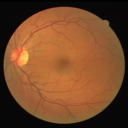

In [ ]:
b=tf.keras.utils.array_to_img(x_test[0])
b

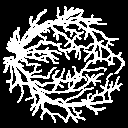

In [ ]:
test_pred = y_test_binary[0]
# new_pred = np.reshape(test_pred, (128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred)
b

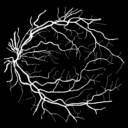

In [ ]:
test_pred = y_test[0]
# new_pred = np.reshape(test_pred, (128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred)
b

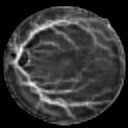

In [ ]:
test_pred = unet_model_onehot.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred[:,:,:,1])
b

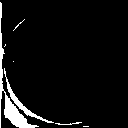

In [ ]:
test_pred = unet_model_onehot.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
y_classes = test_pred.argmax(axis=-1)
y_classes = np.reshape(y_classes,(128,128,1))
b=tf.keras.utils.array_to_img(y_classes)
b

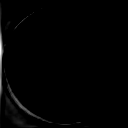

In [ ]:
test_pred = kiunet_model_a1.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred[:,:,:,1])
b

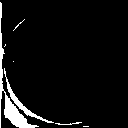

In [ ]:
test_pred = kiunet_model_a1.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
y_classes = test_pred.argmax(axis=-1)
y_classes = np.reshape(y_classes,(128,128,1))
b=tf.keras.utils.array_to_img(y_classes)
b

In [ ]:
unet_model_onehot.fit(x_train, y_onehot_train, batch_size=1, epochs=300, 
                 validation_data=(x_test, y_onehot_test), verbose=1,    ## validation_data = test_data, no early stopping
                 callbacks=keras.callbacks.TensorBoard(log_dir="./logs"))    ## log metrics in TensorBoard

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/300
20/20 [==============================] - 3s 70ms/step - loss: 2.3919 - accuracy: 0.2514 - val_loss: 3.6835 - val_accuracy: 0.1531
Epoch 2/300
20/20 [==============================] - 1s 27ms/step - loss: 1.5536 - accuracy: 0.2152 - val_loss: 2.6562 - val_accuracy: 0.1185
Epoch 3/300
20/20 [==============================] - 0s 14ms/step - loss: 1.2787 - accuracy: 0.2029 - val_loss: 1.3521 - val_accuracy: 0.0415
Epoch 4/300
20/20 [==============================] - 0s 18ms/step - loss: 1.1576 - accuracy: 0.1914 - val_loss: 0.6835 - val_accuracy: 0.0000e+00
Epoch 5/300
20/20 [==============================] - 0s 18ms/step - loss: 1.0655 - accuracy: 0.1821 - val_loss: 0.6564 - val_accuracy: 0.0000e+00
Epoch 6/300
20/20 [==============================] - 0s 17ms/step - loss: 1.0169 - accuracy: 0.1825 - val_loss: 0.6448 - val_accuracy: 0.0000e+00
Epoch 7/300
20/20 [==============================] - 0s 22ms/step - loss: 1.0019 - accuracy: 0.1793 - val_loss: 0.6562 - val_accuracy: 0

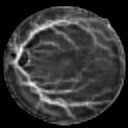

In [ ]:
test_pred = unet_model_onehot.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred[:,:,:,1])
b

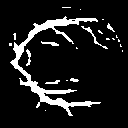

In [ ]:
test_pred = unet_model_onehot.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
y_classes = test_pred.argmax(axis=-1)
# y_classes = np.reshape(y_classes,(128,128,1))
b=tf.keras.utils.array_to_img(y_classes)
b

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_classes, y_test[0])
m.result().numpy()

0.44775027

In [ ]:
# Save the entire model

## Define path to saved directory
#save_dir = 'INSERT_PATH_TO_DIR'

## Save using SavedModel format
unet_model_onehot.save('unet_model_pb')

## Save again using H5 format
unet_model_onehot.save('unet_model_h5.h5', save_format='h5')

INFO:tensorflow:Assets written to: unet_model_pb/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
kiunet_model_a1.fit(x_train, y_onehot_train, batch_size=1, epochs=300, 
                 validation_data=(x_test, y_onehot_test), verbose=1,    ## validation_data = test_data, no early stopping
                 callbacks=keras.callbacks.TensorBoard(log_dir="./logs"))    ## log metrics in TensorBoard

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/300
20/20 [==============================] - 7s 243ms/step - loss: 4.1699 - accuracy: 0.3302 - val_loss: 5.0022 - val_accuracy: 0.2742
Epoch 2/300
20/20 [==============================] - 4s 198ms/step - loss: 2.2332 - accuracy: 0.2485 - val_loss: 4.1106 - val_accuracy: 0.2234
Epoch 3/300
20/20 [==============================] - 4s 227ms/step - loss: 1.7094 - accuracy: 0.2117 - val_loss: 5.8184 - val_accuracy: 0.3729
Epoch 4/300
20/20 [==============================] - 4s 181ms/step - loss: 1.2891 - accuracy: 0.1877 - val_loss: 5.9641 - val_accuracy: 0.3948
Epoch 5/300
20/20 [==============================] - 5s 231ms/step - loss: 1.0877 - accuracy: 0.1793 - val_loss: 4.9260 - val_accuracy: 0.3395
Epoch 6/300
20/20 [==============================] - 4s 206ms/step - loss: 0.9747 - accuracy: 0.1761 - val_loss: 2.9782 - val_accuracy: 0.1975
Epoch 7/300
20/20 [==============================] - 4s 201ms/step - loss: 0.8986 - accuracy: 0.1731 - val_loss: 0.9742 - val_accuracy: 0.0444

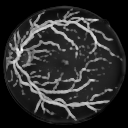

In [ ]:
test_pred = kiunet_model_a1.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred[:,:,:,1])
b

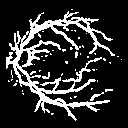

In [ ]:
test_pred = kiunet_model_a1.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
y_classes = test_pred.argmax(axis=-1)
# y_classes = np.reshape(y_classes,(128,128,1))
b=tf.keras.utils.array_to_img(y_classes)
b

In [ ]:
m1 = tf.keras.metrics.MeanIoU(num_classes=2)
m1.update_state(y_classes, y_test_binary[0])
m1.result().numpy()

0.64796066

In [ ]:
# Save the entire model

## Define path to saved directory
#save_dir = 'INSERT_PATH_TO_DIR'

## Save using SavedModel format
kiunet_model_a1.save('kiUnet_model_pb_3d_a')

## Save again using H5 format
kiunet_model_a1.save('kiUnet_model2_3d_a.h5', save_format='h5')

INFO:tensorflow:Assets written to: kiUnet_model_pb_3d_a/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Load trained model

In [9]:
# from tensorflow import keras
# from tensorflow import saved_model as sm

unet_reconstructed = keras.models.load_model('unet_model_h5.h5')

TypeError: __init__() got an unexpected keyword argument 'axis'

In [10]:
# from tensorflow import keras
# from tensorflow import saved_model as sm

kiunet_reconstructed = keras.models.load_model('kiUnet_model2_3d_a.h5')

TypeError: __init__() got an unexpected keyword argument 'axis'

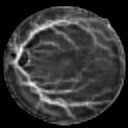

In [ ]:
test_pred = unet_reconstructed.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred[:,:,:,1])
b

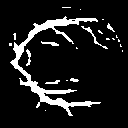

In [ ]:
test_pred = unet_reconstructed.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
y_classes = test_pred.argmax(axis=-1)
# y_classes = np.reshape(y_classes,(128,128,1))
b=tf.keras.utils.array_to_img(y_classes)
b

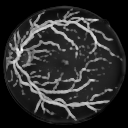

In [ ]:
test_pred = kiunet_reconstructed.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
b=tf.keras.utils.array_to_img(test_pred[:,:,:,1])
b

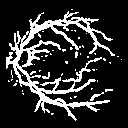

In [ ]:
test_pred = kiunet_reconstructed.predict(x_test[0][tf.newaxis, ...])
test_pred = np.reshape(test_pred,(128,128,1,2))
y_classes = test_pred.argmax(axis=-1)
# y_classes = np.reshape(y_classes,(128,128,1))
b=tf.keras.utils.array_to_img(y_classes)
b

In [ ]:
max_iou = 0
max_f1 = 0
m1 = tf.keras.metrics.MeanIoU(num_classes=2)
m2 = tfa.metrics.F1Score(num_classes=2)
for i in range(20):
  test_pred = kiunet_reconstructed.predict(x_test[i][tf.newaxis, ...])
  test_pred = np.reshape(test_pred,(128,128,1,2))
  y_classes = test_pred.argmax(axis=-1)
  y_classes = tf.cast(y_classes, tf.float32)
  m1.update_state(y_classes, y_test_binary[i])
  curr_m = m1.result().numpy()
  curr_f1 = m2.result().numpy()
  if curr_m > max_iou:
    max_iou = curr_m
  curr_f1 = f1_metric(y_classes, y_test_binary[i])
  if curr_f1 > max_f1:
    max_f1 = curr_f1
print(max_iou)
print(max_f1)

0.64796066
tf.Tensor(0.7180939, shape=(), dtype=float32)


In [ ]:
max = 0
max_iou = 0
max_f1 = 0
m1 = tf.keras.metrics.MeanIoU(num_classes=2)
for i in range(20):
  test_pred = unet_reconstructed.predict(x_test[i][tf.newaxis, ...])
  test_pred = np.reshape(test_pred,(128,128,1,2))
  y_classes = test_pred.argmax(axis=-1)
  y_classes = tf.cast(y_classes, tf.float32)
  m1.update_state(y_classes, y_test_binary[i])
  curr_m = m1.result().numpy()
  if curr_m > max_iou:
    max_iou = curr_m
  curr_f1 = f1_metric(y_classes, y_test_binary[i])
  if curr_f1 > max_f1:
    max_f1 = curr_f1
print(max_iou)
print(max_f1)

0.5569787
tf.Tensor(0.6955127, shape=(), dtype=float32)


In [ ]:
from google.colab import files
files.download("kiUnet_model2_3d_a.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>